<a href="https://colab.research.google.com/github/prayaspatnaik21/HPC/blob/main/GreyScaleConversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get remove libopencv-dev
!apt-get update
!apt-get install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  adwaita-icon-theme dbus-user-session dconf-gsettings-backend dconf-service gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme libatk-bridge2.0-0 libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavcodec-dev libavformat-dev libavutil-dev libcharls2 libcolord2 libdc1394-dev
  libdconf1 libdouble-conversion3 libepoxy0 libexif-dev libexif12 libgdcm-dev libgdcm3.0
  libgl2ps1.4 libglew2.2 libgphoto2-6 libgphoto2-dev libgphoto2-port12
  libgstreamer-plugins-base1.0-0 libgtk-3-0 libgtk-3-common libilmbase-dev libilmbase25 liblept5
  libopencv-calib3d-dev libopencv-calib3d4.5d libopencv-contrib-dev libopencv-contrib4.5d
  libopencv-core-dev libopencv-core4.5d libopencv-dnn-dev libopencv-dnn4.5d
  libopencv-features2d-dev libopencv-features2d4.5d libopencv-flann-dev libopencv-flann4.5d
  libopencv-highgui-dev l

In [ ]:
import cv2
import numpy as np
import urllib.request
from matplotlib import pyplot as plt

# **Updated URL to the raw image file**
url = "https://raw.githubusercontent.com/prayaspatnaik21/DataSet/main/Project/103.jpg"
urllib.request.urlretrieve(url, "103.jpg")
print("Image downloaded successfully!")

Image downloaded successfully!


In [ ]:
# Grey Scale Conversion
%%writefile greyScaleConversion.cu
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include <iostream>

const int CHANNELS = 3;  // RGB channels

// CUDA kernel for grayscale conversion
__global__ void rgbToGrayScale(unsigned char* pOut, unsigned char* pIn, int width, int height)
{
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if (col < width && row < height)
    {
        int grayOffset = row * width + col;
        int rgbOffset = grayOffset * CHANNELS;

        unsigned char r = pIn[rgbOffset];
        unsigned char g = pIn[rgbOffset + 1];
        unsigned char b = pIn[rgbOffset + 2];

        // Grayscale conversion formula
        pOut[grayOffset] = static_cast<unsigned char>(0.299f * r + 0.587f * g + 0.114f * b);
    }
}

cv::Mat getImage()
{
    // Read the image (in BGR format by default)
    cv::Mat img = cv::imread("103.jpg");
    if (img.empty()) {
        std::cerr << "Error: Could not load image!" << std::endl;
        exit(-1);
    }
    return img;
}

int main()
{
    // Get image from disk
    cv::Mat img = getImage();
    int width = img.cols;
    int height = img.rows;
    int channels = img.channels();

    std::cout << "Image width: " << width << std::endl;
    std::cout << "Image height: " << height << std::endl;
    std::cout << "Image channels: " << channels << std::endl;

    int numPixels = width * height;

    // Create an empty grayscale image (1 channel)
    cv::Mat grayImg(height, width, CV_8UC1);

    // Allocate memory on the device
    unsigned char* pIn;
    unsigned char* pOut;
    cudaMalloc(&pIn, numPixels * CHANNELS);  // Allocate memory for the input image (RGB)
    cudaMalloc(&pOut, numPixels);           // Allocate memory for the output grayscale image

    // Copy the input image data to the device
    cudaMemcpy(pIn, img.data, numPixels * CHANNELS, cudaMemcpyHostToDevice);

    // Define block and grid sizes
    dim3 blockDim(16, 16);
    dim3 gridDim((width + blockDim.x - 1) / blockDim.x, (height + blockDim.y - 1) / blockDim.y);
    printf("Grid dimensions: (%d, %d)\n", gridDim.x, gridDim.y);
    // Launch the CUDA kernel
    rgbToGrayScale<<<gridDim, blockDim>>>(pOut, pIn, width, height);

    // Check for kernel launch errors
    cudaError_t err = cudaGetLastError();
    if (err != cudaSuccess) {
        std::cerr << "CUDA kernel launch failed: " << cudaGetErrorString(err) << std::endl;
        return -1;
    }

    // Wait for kernel to finish
    cudaDeviceSynchronize();

    // Copy the result back to the host
    cudaMemcpy(grayImg.data, pOut, numPixels, cudaMemcpyDeviceToHost);

    // Save the grayscale image
    cv::imwrite("gray_image.jpg", grayImg);

    // Free device memory
    cudaFree(pIn);
    cudaFree(pOut);

    return 0;
}


Overwriting greyScaleConversion.cu


In [ ]:
!nvcc greyScaleConversion.cu -o greyScaleConversion -I/usr/include/opencv4 `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
!./greyScaleConversion

Image width: 150
Image height: 150
Image channels: 3
Grid dimensions: (10, 10)


In [ ]:
import cv2
import matplotlib.pyplot as plt

Width: 150, Height: 150


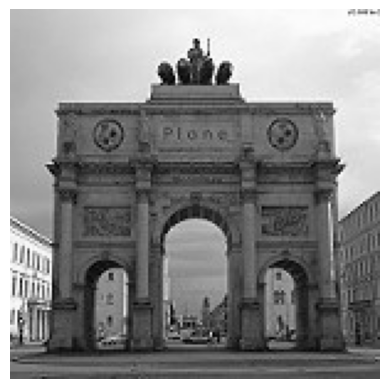

In [ ]:

# Load an image
image = cv2.imread('gray_image.jpg')

# Get image dimensions
height, width,_ = image.shape

print(f"Width: {width}, Height: {height}")
plt.imshow(image)
plt.axis('off')
plt.show()

Width: 150, Height: 150


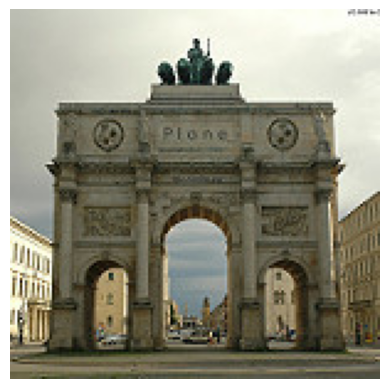

In [ ]:
image = cv2.imread('103.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Get image dimensions
height, width,_ = image.shape

print(f"Width: {width}, Height: {height}")
plt.imshow(image)
plt.axis('off')
plt.show()